# Training STRFs with cross validation

Often we want to get STRF predictions for our entire dataset. To do this, we can perform cross-validation to loop through the dataset, train a model on part, and predict on the rest, until we have predicted all of the trials in the dataset without ever training on the same data we are going to predict.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from scipy.signal import resample

import naplib as nl

In [4]:
# data = nl.io.load_speech_task_data()
data = nl.io.import_outstruct('../out_structs/demo_data.mat')

# for faster runtime, let's just use the first 4 trials
data = data[:4]
print(f'This data has {len(data)} trials')

This data has 4 trials


In [5]:
# # get auditory spectrogram for each stimulus sound
data['spec'] = [nl.features.auditory_spectrogram(trial['sound'], 11025) for trial in data]

# make sure the spectrogram is the exact same size as the responses
data['spec'] = [resample(trial['spec'], trial['resp'].shape[0]) for trial in data]

# resample from 128 frequency bins to 32
data['spec'] = [resample(trial['spec'], 32, axis=1) for trial in data]

In [6]:
# This data contains the fields 'aud' and 'resp', which give the stimulus and neural responses
print(f"aud stimulus shape for first trial : {data[0]['spec'].shape}")
print(f"response shape for first trial : {data[0]['resp'].shape}")

aud stimulus shape for first trial : (6197, 32)
response shape for first trial : (6197, 10)


In [7]:
# Normalize the responses
data['resp'] = nl.preprocessing.normalize(data=data, field='resp')

### Fit STRFs and make predictions using cross validation

We use cross validation to train STRFs on different subsets of the data and predict the withheld portion.

We use the KFold class in naplib.model_selection, which allows us to split an Data into different folds.

In [8]:
tmin = 0 # receptive field begins at time=0
tmax = 0.3 # receptive field ends at a lag of 0.3 seconds
sfreq = 100 # sampling frequency of data

In [9]:
# Use this to split the data into 4 sections for training and testing
# Each test split will have 1 trial each, since the full data we are using is 4 trials
kfold = nl.model_selection.KFold(4)

In [10]:
predictions = []
for i, (train_data, test_data) in enumerate(kfold.split(data)):
    print(f'Xval fold {i}')
    strf_model = nl.encoding.TRF(tmin, tmax, sfreq, estimator=Ridge(), verbose=1)
    strf_model.fit(data=train_data)
    preds = strf_model.predict(data=test_data)
    # preds is a list of the same length as test_data, so we need to append each
    # of its elements to the list of predictions in order to store all the trials'
    # predictions together
    for pred in preds:
        predictions.append(pred)
    

Xval fold 0


  0%|          | 0/10 [00:00<?, ?it/s]

Xval fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

Xval fold 2


  0%|          | 0/10 [00:00<?, ?it/s]

Xval fold 3


  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
print(f'Predictions are length: {len(predictions)}')

Predictions are length: 4


### Analyze the STRF predictions

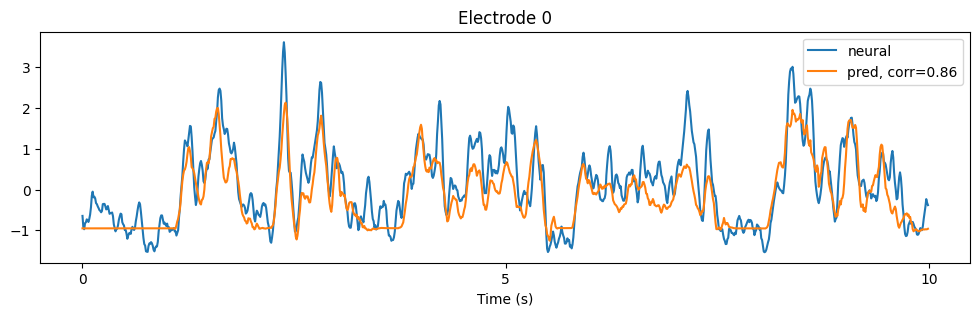

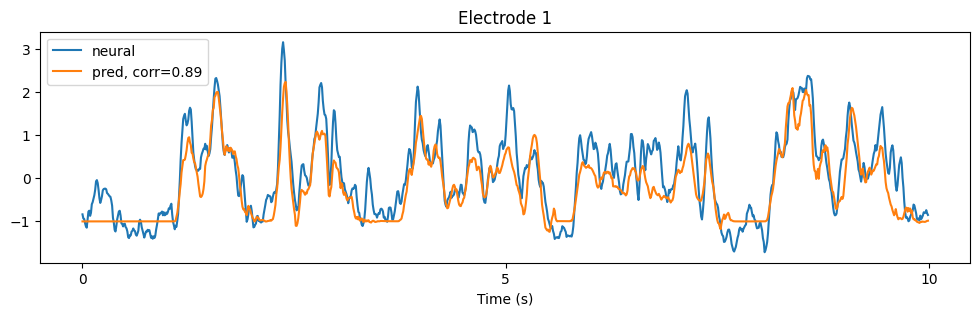

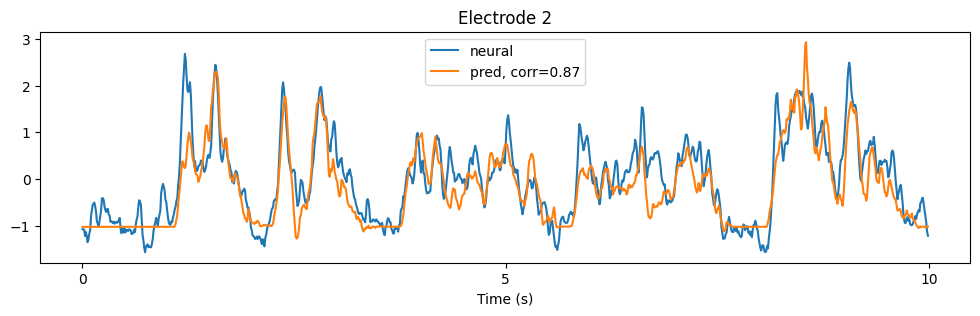

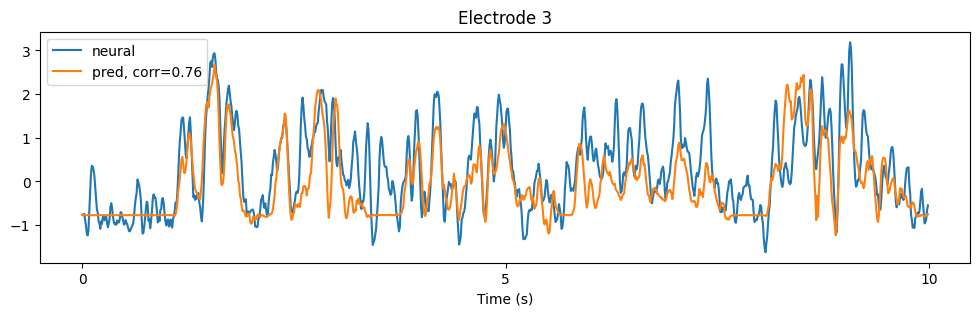

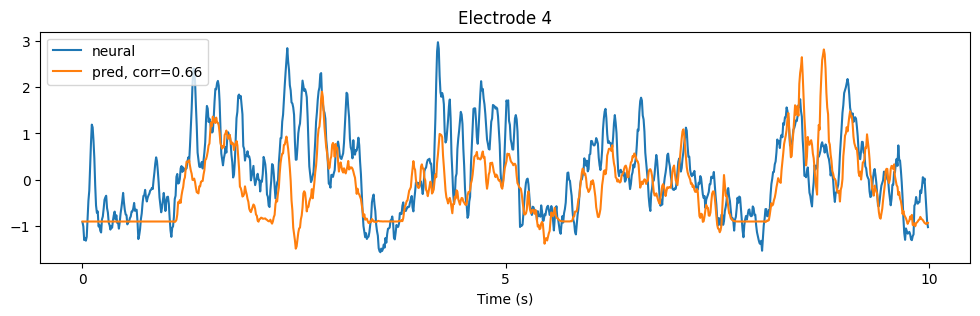

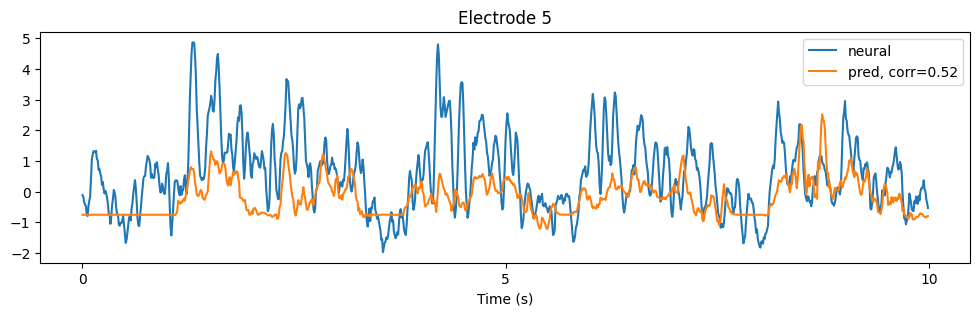

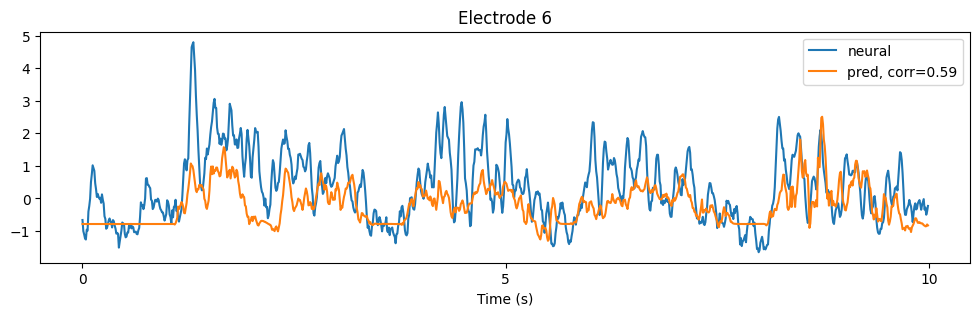

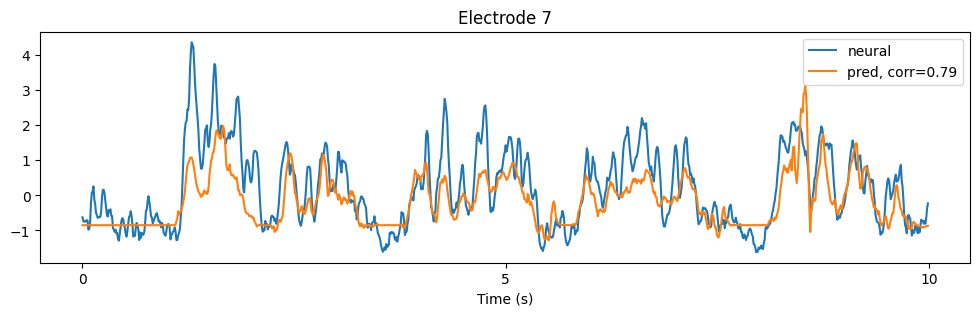

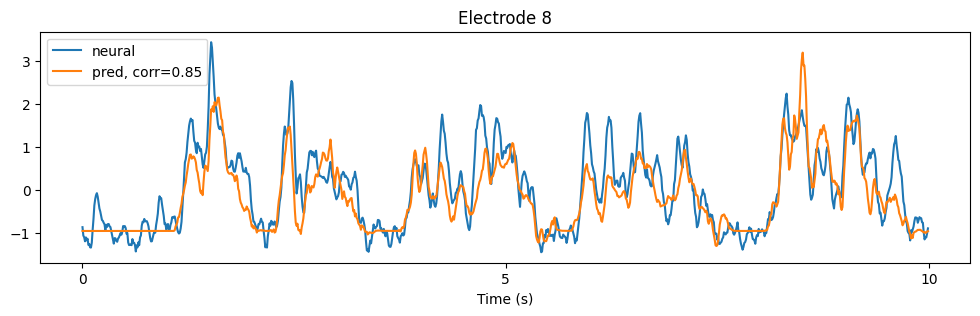

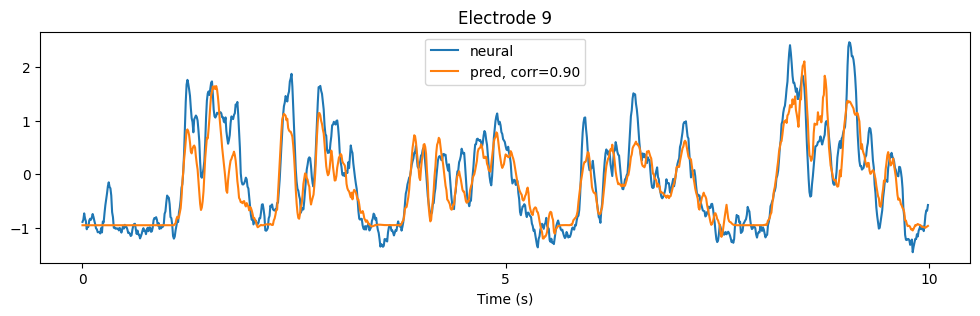

In [12]:
# plot the predictions for the first 20 seconds of the first trial for each electrode

trial = 0
for elec in range(predictions[trial].shape[1]):

    plt.figure(figsize=(12,3))
    score = np.corrcoef(data['resp'][trial][:1000,elec], predictions[trial][:1000,elec])[0,1]
    plt.plot(data['resp'][trial][:1000,elec], label='neural')
    plt.plot(predictions[trial][:1000,elec], label='pred, corr={:2.2f}'.format(score))
    plt.xticks([0, 500, 1000], ['0', '5', '10'])
    plt.xlabel('Time (s)')
    plt.legend()
    plt.title(f'Electrode {elec}')
    plt.show()


